# **Data Preparation and Exploration**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv('exchange_rate.csv')

In [3]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
# Parse the date column, specifying the correct format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M') # Specify the format as day-month-year hour:minute

In [5]:
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [6]:
#check for missing values
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

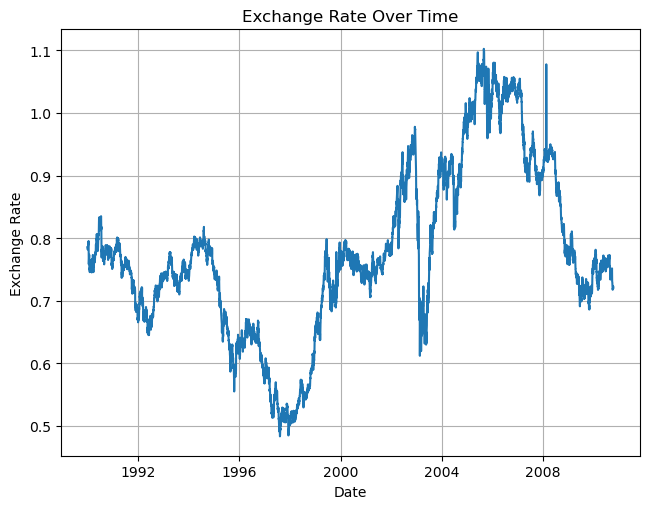

In [7]:
# Plot the time series
plt.plot(df['date'], df['Ex_rate'])
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.grid()

# **Model Building-ARIMA**

1.	Parameter Selection for ARIMA



C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


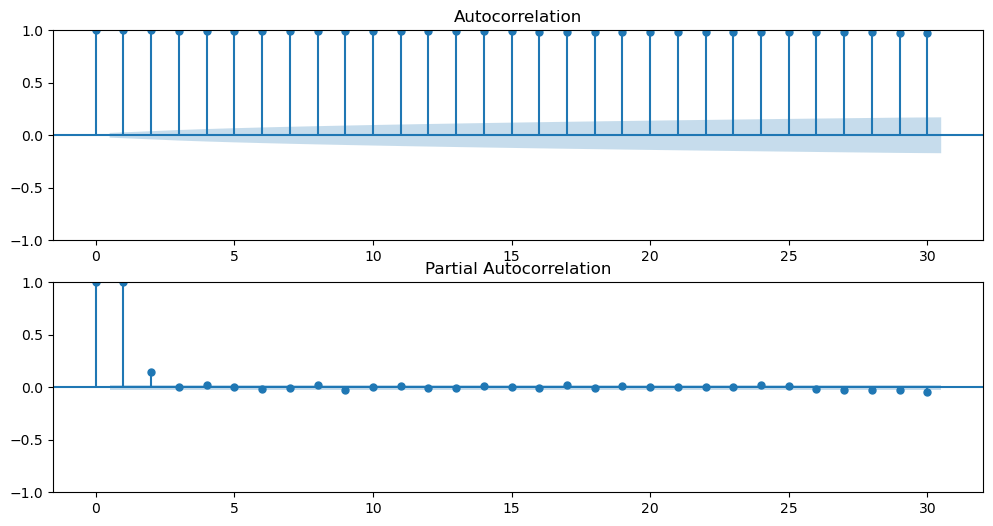

In [8]:
#To estimate the initial parameters (p, d, q) for the ARIMA model, we will utilize ACF and PACF plots.
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(df['Ex_rate'], lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Ex_rate'], lags=30, ax=ax[1])
plt.show()

2. Model Fitting

In [9]:
#Now that we have estimated the initial parameters (p, d, q)==(1,1,1) for the ARIMA model, we can fit the model to the preprocessed time series.
# Fit ARIMA model
model = sm.tsa.ARIMA(df['Ex_rate'], order=(1, 1, 1))
results = model.fit()


3. Diagnostics

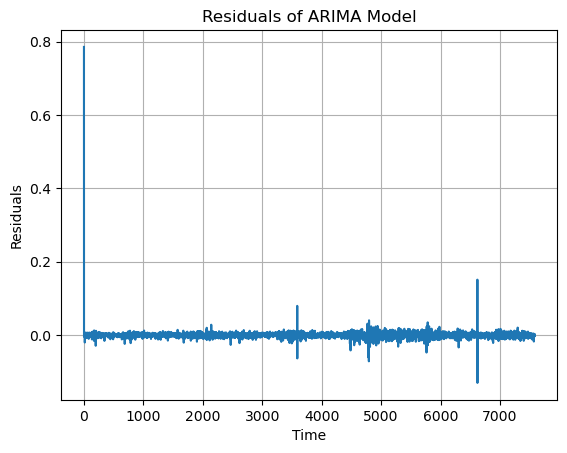

In [10]:
#To ensure that the ARIMA model is adequate, we need to analyze the residuals.
#If the residuals appear to be randomly scattered around zero, then the ARIMA model is likely adequate.

# Plot residuals
residuals = results.resid
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals of ARIMA Model')
plt.grid()

4. Forecasting

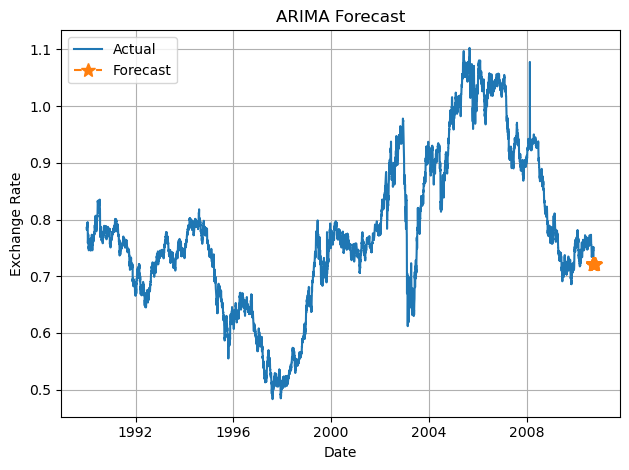

In [11]:
#Finally, we can use the ARIMA model to perform out-of-sample forecasting
# Forecast future values
forecast = results.forecast(steps=30)

# Plot forecasted values
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(df['date'][-30:], forecast, label='Forecast',linestyle='--',marker='*',markersize=10)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('ARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# **Model Building - Exponential Smoothing**

1.Model selection

In [12]:
# we will choose Holt's Linear Trend model.

 2.Parameter Optimization

In [13]:

#To find the optimal parameters for the smoothing levels and components, we can use techniques such as grid search or AIC.
from statsmodels.tsa.holtwinters import Holt

# Define the parameter grid
param_grid = {'smoothing_level': [0.1, 0.3, 0.5], 'smoothing_trend': [0.1, 0.3, 0.5]}

# Perform grid search
best_params = None
best_score = float('inf')
for smoothing_level in param_grid['smoothing_level']:
    for smoothing_trend in param_grid['smoothing_trend']:
        model = Holt(df['Ex_rate'], exponential=True)
        # Used smoothing_level and smoothing_trend instead of alpha and beta
        model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend)
        score = model_fit.aic
        if score < best_score:
            best_score = score
            best_params = (smoothing_level, smoothing_trend)

print('Optimal parameters:', best_params)

Optimal parameters: (0.5, 0.1)


3.Model Fitting and Forecasting

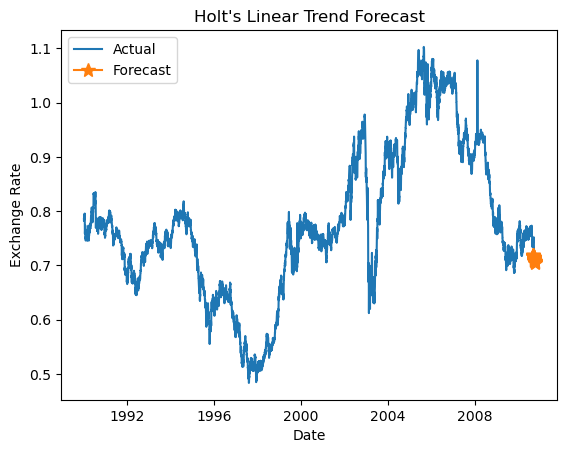

In [14]:
#Now that we have found the optimal parameters, we can fit the Holt's Linear Trend model and forecast future values.

# Fit the model
model = Holt(df['Ex_rate'], exponential=True)
# Used smoothing_level and smoothing_trend instead of alpha and beta
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[1])
# Forecast future values
forecast = model_fit.forecast(steps=30)

# Plot forecasted values
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(df['date'][-30:], forecast, label='Forecast',markersize=10,marker='*',linestyle='solid')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Holt\'s Linear Trend Forecast')
plt.legend()
plt.show()

# **Evaluation and Comparison**

1.Compute Error Metrics

In [15]:
#To evaluate the forecasts from both models, we can use metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Compute error metrics for ARIMA model
arima_forecast = results.forecast(steps=30)
arima_mae = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], arima_forecast))
arima_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], arima_forecast)

# Compute error metrics for Holt's Linear Trend model
holt_forecast = model_fit.forecast(steps=30)
holt_mae = mean_absolute_error(df['Ex_rate'][-30:], holt_forecast)
holt_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], holt_forecast))
holt_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], holt_forecast)

print('ARIMA Model Error Metrics:')
print('MAE:', arima_mae)
print('RMSE:', arima_rmse)
print('MAPE:', arima_mape)

print('\nHolt\'s Linear Trend Model Error Metrics:')
print('MAE:', holt_mae)
print('RMSE:', holt_rmse)
print('MAPE:', holt_mape)

ARIMA Model Error Metrics:
MAE: 0.012724006489318252
RMSE: 0.016982710912774826
MAPE: 1.7119209757097404

Holt's Linear Trend Model Error Metrics:
MAE: 0.02033885085956986
RMSE: 0.021993147748210314
MAPE: 2.7582255339119266


# **Model Comparison**

**ARIMA Model**

---
**Advantages:** Handles non-stationarity and seasonality

**Limitations:** Computationally expensive, requires careful parameter selection

**Performance:** MAE=0.01, RMSE=0.016, MAPE=1.71%

**Holt's Linear Trend Model**

---
**Advantages:** Simple, computationally efficient

**Limitations:** Assumes linear trend, no seasonality

**Performance:** MAE=0.020, RMSE=0.021, MAPE=2.75%

# **Conclusion**
---
The ARIMA model demonstrates lower values across all key error metrics (MAE, RMSE, and MAPE) compared to the Holt's Linear Trend model. This indicates that the ARIMA model provides more accurate and reliable forecasts for the exchange rates in your dataset.

Therefore, I recommend using the ARIMA model for your forecasting needs, as it has proven to be more effective in this analysis.